## Ch5: Anomaly Detection in Network Traffic with K-mean Clustering

### Spark Session

In [1]:
import gc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import Row

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler, MinMaxScaler, PCA
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
EXECUTOR_MEMORY = "5g"
EXECUTOR_CORES = 2
EXECUTORE_INSTANCES = 5
DRIVER_MEMORY = "5g"
DRIVER_MAX_RESULT_SIZE = "5g"

In [3]:
spark = (
    SparkSession.builder.appName(f"CH5")
    .config("spark.executor.memory", EXECUTOR_MEMORY)
    .config("spark.executor.cores", EXECUTOR_CORES)
    .config("spark.executor.instances", EXECUTORE_INSTANCES)
    .config("spark.driver.memory", DRIVER_MEMORY)
    .config("spark.driver.maxResultSize", DRIVER_MAX_RESULT_SIZE)
    .config("spark.kryoserializer.buffer.max", "1024m")
#     .config("spark.sql.warehouse.dir", "/user/bigdata/members/shyeon/advanced-spark/data")
    .enableHiveSupport()
    .getOrCreate()
)

spark.sparkContext.getConf().getAll()

[('spark.driver.extraJavaOptions',
  '"-Dio.netty.tryReflectionSetAccessible=true"'),
 ('spark.kryoserializer.buffer.max', '1024m'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'CH5'),
 ('spark.executor.memory', '5g'),
 ('spark.executor.cores', '2'),
 ('spark.driver.memory', '5g'),
 ('spark.driver.maxResultSize', '5g'),
 ('spark.driver.host', 'ce648118105d'),
 ('spark.executor.extraJavaOptions',
  '"-Dio.netty.tryReflectionSetAccessible=true"'),
 ('spark.executor.instances', '5'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.app.id', 'local-1612175933699'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '35532'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

## Load Data

In [4]:
schema = [
    T.StructField("duration", T.IntegerType(), True),
    T.StructField("protocol_type", T.StringType(), True),
    T.StructField("service", T.StringType(), True),
    T.StructField("flag", T.StringType(), True), 
    T.StructField("src_bytes", T.IntegerType(), True), 
    T.StructField("dst_bytes", T.IntegerType(), True), 
    T.StructField("land", T.IntegerType(), True), 
    T.StructField("wrong_fragment", T.IntegerType(), True),
    T.StructField("urgent", T.IntegerType(), True),
    T.StructField("hot", T.IntegerType(), True),
    T.StructField("num_failed_logins", T.IntegerType(), True),
    T.StructField("logged_in", T.IntegerType(), True),
    T.StructField("num_compromised", T.IntegerType(), True),
    T.StructField("root_shell", T.IntegerType(), True),
    T.StructField("su_attempted", T.IntegerType(), True),
    T.StructField("num_root", T.IntegerType(), True),
    T.StructField("num_file_creations", T.IntegerType(), True),
    T.StructField("num_shells", T.IntegerType(), True),
    T.StructField("num_access_files", T.IntegerType(), True),
    T.StructField("num_outbound_cmds", T.IntegerType(), True),
    T.StructField("is_host_login", T.DoubleType(), True),
    T.StructField("is_guest_login", T.DoubleType(), True),
    T.StructField("count", T.DoubleType(), True),
    T.StructField("srv_count", T.DoubleType(), True),
    T.StructField("serror_rate", T.DoubleType(), True),
    T.StructField("srv_serror_rate", T.DoubleType(), True),
    T.StructField("rerror_rate", T.DoubleType(), True),
    T.StructField("srv_rerror_rate", T.DoubleType(), True),
    T.StructField("same_srv_rate", T.DoubleType(), True),
    T.StructField("diff_srv_rate", T.DoubleType(), True),
    T.StructField("srv_diff_host_rate", T.DoubleType(), True),
    T.StructField("dst_host_count", T.DoubleType(), True),
    T.StructField("dst_host_srv_count", T.DoubleType(), True),
    T.StructField("dst_host_same_srv_rate", T.DoubleType(), True),
    T.StructField("dst_host_diff_srv_rate", T.DoubleType(), True),
    T.StructField("dst_host_same_src_port_rate", T.DoubleType(), True),
    T.StructField("dst_host_srv_diff_host_rate", T.DoubleType(), True),
    T.StructField("dst_host_serror_rate", T.DoubleType(), True),
    T.StructField("dst_host_srv_serror_rate", T.DoubleType(), True),
    T.StructField("dst_host_rerror_rate", T.DoubleType(), True),
    T.StructField("dst_host_srv_rerror_rate", T.DoubleType(), True),
    T.StructField("label", T.StringType(), True)
    ]

schema = T.StructType(schema)

df = (spark
      .read.format("csv")
      .option("header", False)
      .option("sep", ",")
      .schema(schema)
#       .option("inferSchema", True)
      .load("./data/kddcup.data.corrected"))

# df.printSchema()
df.show(2)
# df.select("label").show(5) # 모든 컬럼의 스키마가 반영되었는지 확인

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_hos

In [5]:
# ===== Check Label Distribution =====
label_df = df.groupBy('label').count().orderBy('count', ascending=False)
label_df = label_df.withColumn('percent', F.col('count')/F.sum('count').over(Window.partitionBy()))
label_df.show(30)   

# [NOTE]
#- 24 labels
#- most of them being smurf and neptune attacks

# [수정]
#- ratio to % and round

+----------------+-------+--------------------+
|           label|  count|             percent|
+----------------+-------+--------------------+
|          smurf.|2807886|  0.5732215070499105|
|        neptune.|1072017|  0.2188490559528143|
|         normal.| 972781| 0.19859032412623553|
|          satan.|  15892|0.003244304145551...|
|        ipsweep.|  12481| 0.00254795872392609|
|      portsweep.|  10413|0.002125782725121...|
|           nmap.|   2316|  4.7280445514084E-4|
|           back.|   2203|4.497358439875952E-4|
|    warezclient.|   1020|2.082299413832715E-4|
|       teardrop.|    979|1.998599143276694...|
|            pod.|    264|5.389480835802321...|
|   guess_passwd.|     53|1.081979107187587...|
|buffer_overflow.|     30|6.124410040684456E-6|
|           land.|     21|4.287087028479119E-6|
|    warezmaster.|     20|4.082940027122970...|
|           imap.|     12|2.449764016273782...|
|        rootkit.|     10|2.041470013561485...|
|     loadmodule.|      9|1.837323012205

In [6]:
def feature_pipeline(data, used_cols):
    
    assembler = VectorAssembler(inputCols = used_cols, outputCol='features')
    ppl = Pipeline(stages = [assembler])
                
    featureDf = ppl.fit(data).transform(data)
    return featureDf

In [7]:
def encoding_pipeline(data, str_cols):

    stage_string = [StringIndexer(inputCol= c, outputCol= c+"_str_encoded") for c in str_cols]
    stage_onehot = [OneHotEncoder(inputCol= c+"_str_encoded", outputCol= c+ "_onehot_vec") for c in str_cols]

    ppl = Pipeline(stages = stage_string + stage_onehot)
    encodedDF = ppl.fit(data).transform(data)
    return encodedDF

# [NOTE]
#-  use a StringIndexer to turn the categorical values into category indices which are then converted into a column of binary vectors by the OneHotEncoder for each of the columns as

In [8]:
def Kmeans_model(data, k, input_col):
    #-- Train k-mean model
    kmeans = KMeans(featuresCol=input_col, predictionCol='prediction', k=k).setSeed(1)
    model = kmeans.fit(data)

    #-- Make Predictions
    predDf = model.transform(data)

    #-- Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predDf)
    print(f"Silhouette with squared euclidean distance with k={k}: {str(silhouette)}")

    #-- Shows the result
    centers = model.clusterCenters()
#     print("\nCluster Centers: ")
#     for center in centers:
#         print(center)
    return predDf

In [9]:
def pca_figure(pred_df, input_col, k):
    pca = PCA(k=k, inputCol=input_col, outputCol="features_pca")
    pca_model = pca.fit(pred_df)
    pcaDf = pca_model.transform(predDf).select("features_pca", "prediction")
    
    pca_df = pcaDf.toPandas()
    
    if k == 2:
        dataX = []
        dataY = []
        for vec in pca_df.values:
            dataX.extend([vec[0][0]])
            dataY.extend([vec[0][1]])
        sns.scatterplot(dataX, dataY, hue=pca_df['prediction'])
        plt.show()
    
    elif k == 3:
        dataX = []
        dataY = []
        dataZ = []
        for vec in pca_df.values:
            dataX.extend([vec[0][0]])
            dataY.extend([vec[0][1]])
            dataZ.extend([vec[0][2]])

        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111, projection='3d') # Axe3D object
        p = ax.scatter(dataX, dataY, dataZ, c=pca_df['prediction'], s=20, alpha=0.5)
        fig.colorbar(p)
        plt.show()
    else:
        pass


In [10]:
def silhouette_scores(data, feature_col, range1, range2, step, print_option=True):
    if range1 < 2:
        print('Range1 needs to be greater than 1')
        cost = 0
    else:
        cost = list()
        evaluator = ClusteringEvaluator()
        for k in range(range1, range2, step):
            kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
            kmeans = KMeans(featuresCol=feature_col, predictionCol='prediction', k=k).setSeed(1)  
            model = kmeans.fit(data)
            predictions = model.transform(data)

            silhouette = evaluator.evaluate(predictions)
            cost.append(silhouette)
            
            if print_option:
                print(k, evaluator.evaluate(predictions))

        #-- max cost
        kIdx = np.argmax(cost)

        #-- cost figure 
        fig, ax = plt.subplots()
        ax.plot(range(range1, range2, step), cost, 'o-')
        ax.plot(range(range1, range2, step)[kIdx], cost[kIdx]
                , marker='o', markersize=14
                , markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
        ax.set_xlabel('Number of clusters')
        ax.set_ylabel('Silhouette Coefficient')
        ax.set_title('Silhouette Scores for k-means clustering')
        plt.show()
    return cost

## Basic K-means Clustering (Without Scaling)

In [11]:
# ===== Data preprocessing =====
num_cols = df.drop('protocol_type', 'service', 'flag', 'label').columns
featureDf = feature_pipeline(df, num_cols)

print(f"Number of columns in featureDf: {len(df.columns)}")
featureDf.select("label", "features").show(5, False)

# [NOTE]
#- transform features on the DataFrame records into FeatureVector
#- VectorAssembler is a transformer that combines a given list of columns into a single vector column. 
#- 저장공간을 절약하기 위해 SparseVector 인스턴스로 표현.

Number of columns in featureDf: 42
+-------+---------------------------------------------------------------------------------+
|label  |features                                                                         |
+-------+---------------------------------------------------------------------------------+
|normal.|(38,[1,2,8,19,20,25],[215.0,45076.0,1.0,1.0,1.0,1.0])                            |
|normal.|(38,[1,2,8,19,20,25,28,29,30,32],[162.0,4528.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0]) |
|normal.|(38,[1,2,8,19,20,25,28,29,30,32],[236.0,1228.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.5]) |
|normal.|(38,[1,2,8,19,20,25,28,29,30,32],[233.0,2032.0,1.0,2.0,2.0,1.0,3.0,3.0,1.0,0.33])|
|normal.|(38,[1,2,8,19,20,25,28,29,30,32],[239.0,486.0,1.0,3.0,3.0,1.0,4.0,4.0,1.0,0.25]) |
+-------+---------------------------------------------------------------------------------+
only showing top 5 rows



In [12]:
# ===== KMeans Model =====
predDf = Kmeans_model(featureDf, 2, "features" )

# -- Check Cluster Distribution
cluster_df = predDf.select("prediction", "label").groupBy('prediction', 'label').count().orderBy('count', ascending=False)
cluster_df.show(30)   

# [NOTE]
#- only one data point ended up in cluster 1

Silhouette with squared euclidean distance with k=2: 0.999998858708827
+----------+----------------+-------+
|prediction|           label|  count|
+----------+----------------+-------+
|         0|          smurf.|2807886|
|         0|        neptune.|1072017|
|         0|         normal.| 972781|
|         0|          satan.|  15892|
|         0|        ipsweep.|  12481|
|         0|      portsweep.|  10412|
|         0|           nmap.|   2316|
|         0|           back.|   2203|
|         0|    warezclient.|   1020|
|         0|       teardrop.|    979|
|         0|            pod.|    264|
|         0|   guess_passwd.|     53|
|         0|buffer_overflow.|     30|
|         0|           land.|     21|
|         0|    warezmaster.|     20|
|         0|           imap.|     12|
|         0|        rootkit.|     10|
|         0|     loadmodule.|      9|
|         0|      ftp_write.|      8|
|         0|       multihop.|      7|
|         0|            phf.|      4|
|         0|     

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


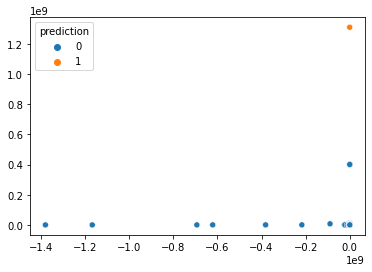

In [13]:
# ===== PCA Figure =====
#-- 2d
pca_figure(predDf, "features", 2)

# [NOTE]
#- Not a very good representation

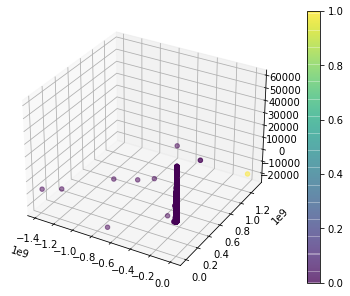

In [15]:
#-- 3d
pca_figure(predDf, "features", 3)

# [NOTE]
#- 평가지표
# 1. 정량적
#--- Elbow method(wss: Within-cluster Sum of Square)
#--- Silhouette coefficient
# 2. 정성적(pca, t-sne)
#--- visualizing to see if clustering is done well 

## K-means Clustering with appropriate K

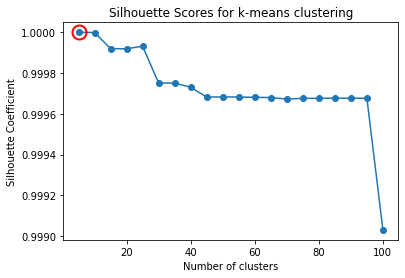

In [13]:
# ===== Choosing K =====
cost = silhouette_scores(featureDf, "features", 5, 101, 5, False)

# [NOTE]
#- 한 군집 내의 데이터들이 다른 군집과 비교해 얼마나 비슷한지를 나타내는 값
#- 클러스터 안의 거리가 짧을 수록 좋고(cohesion), 다른 클러스터와의 거리는 멀수록 좋다(separation)
#- 실루엣은 -1 부터 1사이의 값을 가짐
#- 실루엣 값이 1에 가까울 수록 군집화가 적절히 되었음
#- 실루엣 값이 -1에 가까울 수록 군집 결과가 타당하지 못함
#- 보통 실루엣 지표가 0.5보다 크면 군집 결과가 타당한 것으로 평가함

In [11]:
# ===== KMeans Model =====
predDf = Kmeans_model(featureDf, 5, 'features')

# -- Check Cluster Distribution
cluster_df = predDf.select("prediction", "label").groupBy('prediction', 'label').count().orderBy('count', ascending=False)
cluster_df.show(30)   

Silhouette with squared euclidean distance with k=5: 0.9999994341443229
+----------+----------------+-------+
|prediction|           label|  count|
+----------+----------------+-------+
|         0|          smurf.|2807886|
|         0|        neptune.|1072017|
|         0|         normal.| 972781|
|         0|          satan.|  15892|
|         0|        ipsweep.|  12481|
|         0|      portsweep.|  10405|
|         0|           nmap.|   2316|
|         0|           back.|   2203|
|         0|    warezclient.|   1020|
|         0|       teardrop.|    979|
|         0|            pod.|    264|
|         0|   guess_passwd.|     53|
|         0|buffer_overflow.|     30|
|         0|           land.|     21|
|         0|    warezmaster.|     20|
|         0|           imap.|     12|
|         0|        rootkit.|     10|
|         0|     loadmodule.|      9|
|         0|      ftp_write.|      8|
|         0|       multihop.|      7|
|         0|            phf.|      4|
|         2|    

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


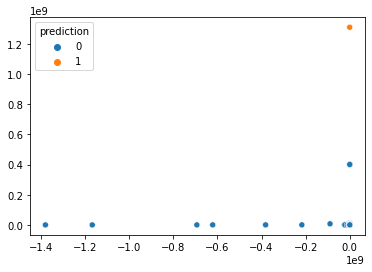

In [13]:
# ===== PCA Figure =====
#-- 2d
pca_figure(predDf, "features", 2)

# [NOTE
#- though appropriat K is used, clustering hasn't improved
#- reason: K-means is sensitive to scaling
#- 거리 기반 클러스터링 분석에서는 개체끼리 특성 차이가 얼마나 나는지 계산을 함
#- 변수끼리 스케일 차이가 크게 벌어지면 스케일이 큰 변수의 영향력이 상대적으로 커지기 때문

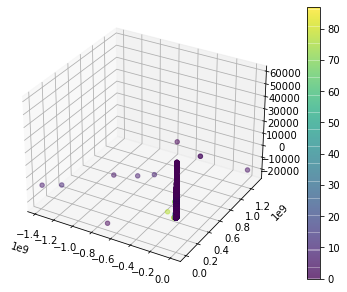

In [16]:
#-- 3d
pca_figure(predDf, "features", 3)

## Kmeans Model after Scaling and Encoding

In [11]:
# ===== Data preprocessing =====
#-- encoding
str_cols = ["protocol_type", "service", "flag", "label"]
encodedDF = encoding_pipeline(df, str_cols)
encodedDF.show(2)

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+-------------------------+-------------------+----------------+-----------------+------------------------+------------------+---------------+----------------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cm

In [12]:
#-- vector assembler
used_cols = df.drop(*str_cols).columns + [c + "_onehot_vec" for c in str_cols]
featureDf_enc = feature_pipeline(encodedDF, used_cols)

print(f"Number of columns used: {len(used_cols)}")
featureDf_enc.select("label", "features").show(5, False)

# [NOTE]
#-  use a StringIndexer to turn the categorical values into category indices which are then converted into a column of binary vectors by the OneHotEncoder for each of the columns as

Number of columns used: 42
+-------+----------------------------------------------------------------------------------------------------------------+
|label  |features                                                                                                        |
+-------+----------------------------------------------------------------------------------------------------------------+
|normal.|(141,[1,2,8,19,20,25,39,42,109,121],[215.0,45076.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                            |
|normal.|(141,[1,2,8,19,20,25,28,29,30,32,39,42,109,121],[162.0,4528.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|normal.|(141,[1,2,8,19,20,25,28,29,30,32,39,42,109,121],[236.0,1228.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.5,1.0,1.0,1.0,1.0]) |
|normal.|(141,[1,2,8,19,20,25,28,29,30,32,39,42,109,121],[233.0,2032.0,1.0,2.0,2.0,1.0,3.0,3.0,1.0,0.33,1.0,1.0,1.0,1.0])|
|normal.|(141,[1,2,8,19,20,25,28,29,30,32,39,42,109,121],[239.0,486.0,1.0,3.0,3.0,1.0,4.0,4.0,1.0,0.25,1.0,1.0,1

In [13]:
# ===== Standard Scaler withStd =====
scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaler_model = scaler.fit(featureDf_enc)
featureDf_scaled = scaler_model.transform(featureDf_enc)
featureDf_scaled.select("label", "features_scaled").show(5, False)

# [NOTE]
#- scalers are applied on vector data types: vector assembler --> scaler
#- A StandardScaler standardizes features by removing the mean and scaling to unit standard deviation using column-summary-statistics.
#- StandardScaler can take two additional parameters:
#- withStd: True by default. Scales the data to unit standard deviation.
#- withMean: False by default. Centers the data with mean before scaling.

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label  |features_scaled                                                                                                                                                                                                                                                                                                                      |
+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

20 0.3446764199409589
40 0.17516537162275425
60 0.2680040201015321
80 0.22777382062322518
100 0.24700451375951277


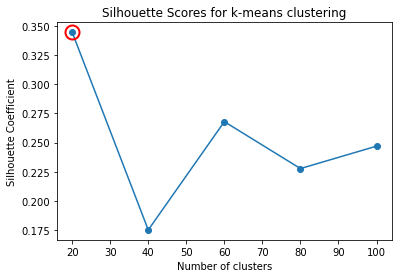

In [15]:
# ===== Choosing K =====
cost = silhouette_scores(featureDf_scaled, "features_scaled", 20, 101, 20, True)

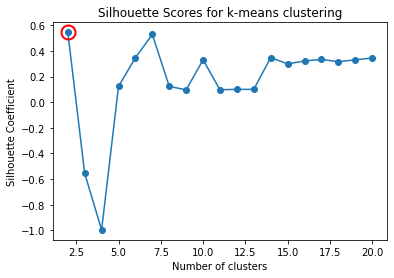

In [16]:
cost = silhouette_scores(featureDf_scaled, "features_scaled", 2, 21, 1, False)

In [13]:
# ===== KMeans Model K=2 =====
predDf = Kmeans_model(featureDf_scaled, 2, "features_scaled")

# -- Check Cluster Distribution
cluster_df = predDf.select("prediction", "label").groupBy('prediction', 'label').count().orderBy('count', ascending=False)
cluster_df.show(30)   

Silhouette with squared euclidean distance with k=2: 0.5455593683713693
+----------+----------------+-------+
|prediction|           label|  count|
+----------+----------------+-------+
|         0|          smurf.|2807886|
|         1|        neptune.|1072017|
|         0|         normal.| 960314|
|         1|          satan.|  15035|
|         1|         normal.|  12467|
|         0|        ipsweep.|  11625|
|         1|      portsweep.|  10404|
|         0|           back.|   2198|
|         0|           nmap.|   1281|
|         1|           nmap.|   1035|
|         0|    warezclient.|   1019|
|         0|       teardrop.|    912|
|         0|          satan.|    857|
|         1|        ipsweep.|    856|
|         0|            pod.|    264|
|         1|       teardrop.|     67|
|         1|   guess_passwd.|     51|
|         0|buffer_overflow.|     29|
|         1|           land.|     21|
|         0|    warezmaster.|     20|
|         0|        rootkit.|     10|
|         0|    

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


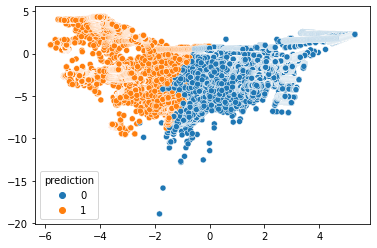

In [15]:
# ===== PCA =====
#-- 2d
pca_figure(predDf, "features_scaled", 2)

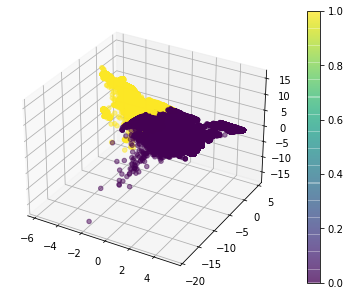

In [17]:
#-- 3d
pca_figure(predDf, "features_scaled", 3)

In [18]:
# ===== KMeans Model k=7 =====
predDf = Kmeans_model(featureDf_scaled, 7, "features_scaled")

# -- Check Cluster Distribution
cluster_df = predDf.select("prediction", "label").groupBy('prediction', 'label').count().orderBy('count', ascending=False)
cluster_df.show(30)   

Silhouette with squared euclidean distance with k=7: 0.5284467802563361
+----------+----------------+-------+
|prediction|           label|  count|
+----------+----------------+-------+
|         1|          smurf.|2807886|
|         2|        neptune.|1068143|
|         0|         normal.| 910536|
|         3|         normal.|  56283|
|         3|          satan.|  15537|
|         0|        ipsweep.|  12282|
|         3|      portsweep.|  10245|
|         6|         normal.|   5017|
|         0|           back.|   2203|
|         6|        neptune.|   1800|
|         0|           nmap.|   1275|
|         5|        neptune.|   1038|
|         4|        neptune.|   1034|
|         2|           nmap.|   1028|
|         0|    warezclient.|   1017|
|         0|       teardrop.|    954|
|         1|         normal.|    914|
|         1|          satan.|    241|
|         0|            pod.|    204|
|         2|        ipsweep.|    184|
|         2|      portsweep.|    132|
|         0|    

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


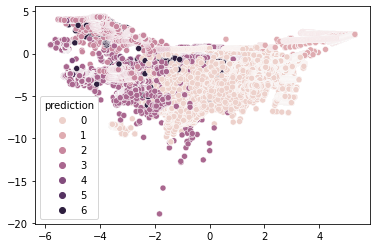

In [20]:
# ===== PCA =====
#-- 2d
pca_figure(predDf, "features_scaled", 2)

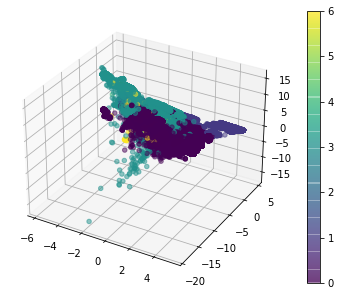

In [22]:
#-- 3d
pca_figure(predDf, "features_scaled", 3)

## KMeans with MaxMin Scaler

In [11]:
# ===== Data preprocessing =====
#-- encoding
str_cols = ["protocol_type", "service", "flag", "label"]
encodedDF = encoding_pipeline(df, str_cols)
encodedDF.show(2)

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+-------------------------+-------------------+----------------+-----------------+------------------------+------------------+---------------+----------------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cm

In [12]:
#-- vector assembler
used_cols = df.drop(*str_cols).columns + [c+ "_onehot_vec" for c in str_cols]
featureDf_enc = feature_pipeline(encodedDF, used_cols)

print(f"Number of columns used: {len(used_cols)}")
featureDf_enc.select("label", "features").show(5, False)

# [NOTE]
#-  use a StringIndexer to turn the categorical values into category indices which are then converted into a column of binary vectors by the OneHotEncoder for each of the columns as

Number of columns used: 42
+-------+----------------------------------------------------------------------------------------------------------------+
|label  |features                                                                                                        |
+-------+----------------------------------------------------------------------------------------------------------------+
|normal.|(141,[1,2,8,19,20,25,39,42,109,121],[215.0,45076.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                            |
|normal.|(141,[1,2,8,19,20,25,28,29,30,32,39,42,109,121],[162.0,4528.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|normal.|(141,[1,2,8,19,20,25,28,29,30,32,39,42,109,121],[236.0,1228.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.5,1.0,1.0,1.0,1.0]) |
|normal.|(141,[1,2,8,19,20,25,28,29,30,32,39,42,109,121],[233.0,2032.0,1.0,2.0,2.0,1.0,3.0,3.0,1.0,0.33,1.0,1.0,1.0,1.0])|
|normal.|(141,[1,2,8,19,20,25,28,29,30,32,39,42,109,121],[239.0,486.0,1.0,3.0,3.0,1.0,4.0,4.0,1.0,0.25,1.0,1.0,1

In [13]:
# ===== MinMax Scaler =====
scaler = MinMaxScaler(min=0, max=1, inputCol="features", outputCol="features_scaled")
scaler_model = scaler.fit(featureDf_enc)
featureDf_scaled = scaler_model.transform(featureDf_enc)
featureDf_scaled.select("label", "features_scaled").show(5, False)

# [NOTE]
#- MinMaxScaler transforms data values to a specific range ([0, 1] by default)

+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label  |features_scaled                                                                                                                                                                                                           |
+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|normal.|(141,[1,2,8,16,19,20,25,39,42,109,121],[1.5580117847257754E-7,3.441080464271742E-5,1.0,0.5,0.0019569471624266144,0.0019569471624266144,1.0,1.0,1.0,1.0,1.0])                                                              |
|normal.|(141,[1,2,8,16,19,20,25,28,29,30,32,39,42,109,121],[1.1739437633747702E-7,3

20 0.3574272917233006
40 0.35855982660899677
60 0.3609448216791528
80 0.374255129265582
100 0.14890856872185282


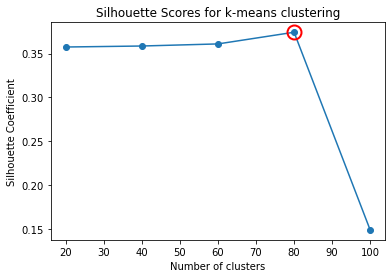

In [14]:
# ===== Choosing K =====
cost = silhouette_scores(featureDf_scaled, "features_scaled", 20, 101, 20, True)

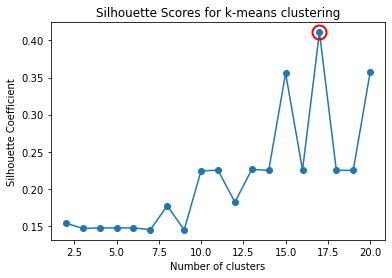

In [14]:
cost = silhouette_scores(featureDf_scaled, "features_scaled", 2, 21, 1, False)

In [14]:
# ===== KMeans Model =====
predDf = Kmeans_model(featureDf_scaled, 17, "features_scaled")

# -- Check Cluster Distribution
cluster_df = predDf.select("prediction", "label").groupBy('prediction', 'label').count().orderBy('count', ascending=False)
cluster_df.show(30)   

# [NOTE]
#- only one data point ended up in cluster 1

Silhouette with squared euclidean distance with k=17: 0.41107787672346174
+----------+------------+-------+
|prediction|       label|  count|
+----------+------------+-------+
|         1|      smurf.|2807818|
|         2|    neptune.| 819730|
|         0|     normal.| 246228|
|        10|     normal.| 205673|
|         3|    neptune.| 204570|
|        13|     normal.| 113819|
|         4|     normal.|  73837|
|         6|     normal.|  57795|
|        12|     normal.|  55942|
|         8|     normal.|  53770|
|        16|     normal.|  53636|
|         5|     normal.|  52662|
|        15|    neptune.|  47716|
|        11|     normal.|  42720|
|         3|      satan.|  12293|
|         7|    ipsweep.|  11557|
|         9|     normal.|  10660|
|        14|  portsweep.|  10011|
|         7|     normal.|   5984|
|         0|       back.|   1649|
|        15|      satan.|   1575|
|         9|      satan.|   1348|
|         7|       nmap.|   1032|
|         8|warezclient.|   1018|
|       

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


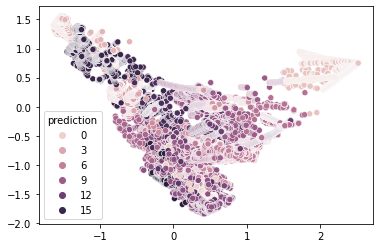

In [15]:
# ===== PCA =====
#-- 2d
pca_figure(predDf, "features_scaled", 2)

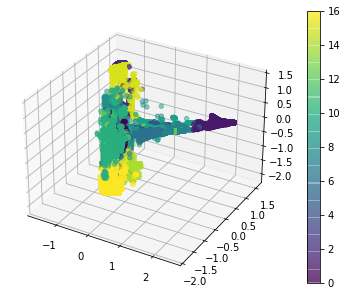

In [16]:
#-- 3d
pca_figure(predDf, "features_scaled", 3)